<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
# загрузка библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression # линейная регрессия 
from sklearn.metrics import r2_score # R2 

# для phik-коэффициента корреляции
import phik
from phik.report import plot_correlation_matrix
from phik import report

# для VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# МНК отчет
import statsmodels.api as sm
from scipy import stats

In [2]:
# загрузка данных

df = pd.read_csv('/datasets/insurance.csv')

In [3]:
# посмотрим
display(df.sample(10))

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
3843,1,46.0,48000.0,0,1
4669,0,46.0,26900.0,1,1
4692,1,28.0,38400.0,3,0
4141,0,28.0,40300.0,0,0
2303,0,28.0,43000.0,0,0
1335,1,23.0,47200.0,0,0
2394,1,26.0,51900.0,0,0
3113,1,39.0,47100.0,1,0
2156,1,23.0,43500.0,1,0
1101,1,24.0,29600.0,0,0


In [4]:
# есть ли пропуски?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
# возраст и зарплата это целые числа

df['Возраст'] = df['Возраст'].astype('int')
df['Зарплата'] = df['Зарплата'].astype('int')

In [6]:
# нет ли отрицательных значений

df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [7]:
# разделим на фичи и таргет
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

<AxesSubplot:>

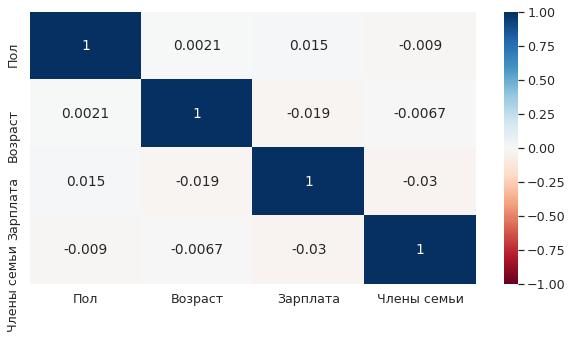

In [8]:
# проверим нет ли корреляций между параметрами
sns.set(font_scale=1.15)
plt.figure(figsize=(10,5))
sns.heatmap(
    features.corr(),        
    cmap='RdBu', 
    annot=True, 
    vmin=-1, vmax=1)

Если смотреть на коэффициент корреляции Пирсона, корреляции м-ду возрастом и зарплатой как будто бы нет, хотя здравый смысл подсказывает обратное. Что-то из них распределено не нормально.

In [15]:
# установим
pip install phik

     |████████████████████████████████| 679 kB 13 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
# фик-корреляция
phik_overview = features.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Пол', 'Возраст', 'Зарплата', 'Члены семьи']


,Пол,Возраст,Зарплата,Члены семьи
Пол,1.0,0.00,0.00,0.0
Возраст,0.0,1.00,0.07,0.0
Зарплата,0.0,0.07,1.00,0.0
Члены семьи,0.0,0.00,0.00,1.0


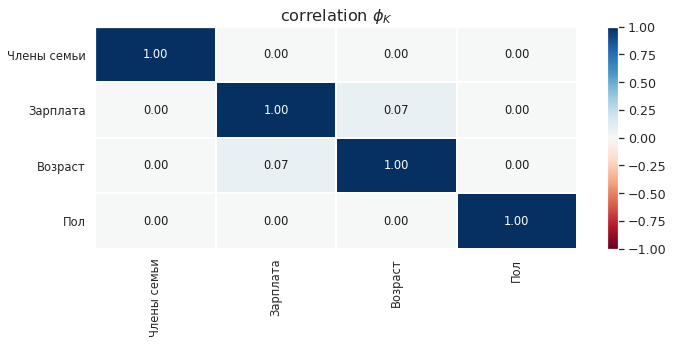

In [20]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=-1, vmax=1, color_map="RdBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.15, 
                        figsize=(10, 5))
plt.tight_layout()

C phik коэффициентом уже видно, что слабая положительная связь м-ду возрастом и зарплатой есть.

In [26]:
display(df.head(5))

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


In [27]:
# переименуем столбцы, чтобы сработал код ниже
df.columns = ['sex', 'age', 'wage', 'family', 'insurance']

In [28]:
display(df.head(5))

,sex,age,wage,family,insurance
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


In [29]:
# еще можно мультиколинеарность через VIF (коэффициент вздутия дисперсии) смотреть

y, X = dmatrices('insurance ~ sex+age+wage+family', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
print(vif)

         VIF   variable
0  33.716802  Intercept
1   1.000301        sex
2   1.000423        age
3   1.001508       wage
4   1.001044     family


Низкие значения VIF говорят в пользу того, что мультиколлинеарности нет.

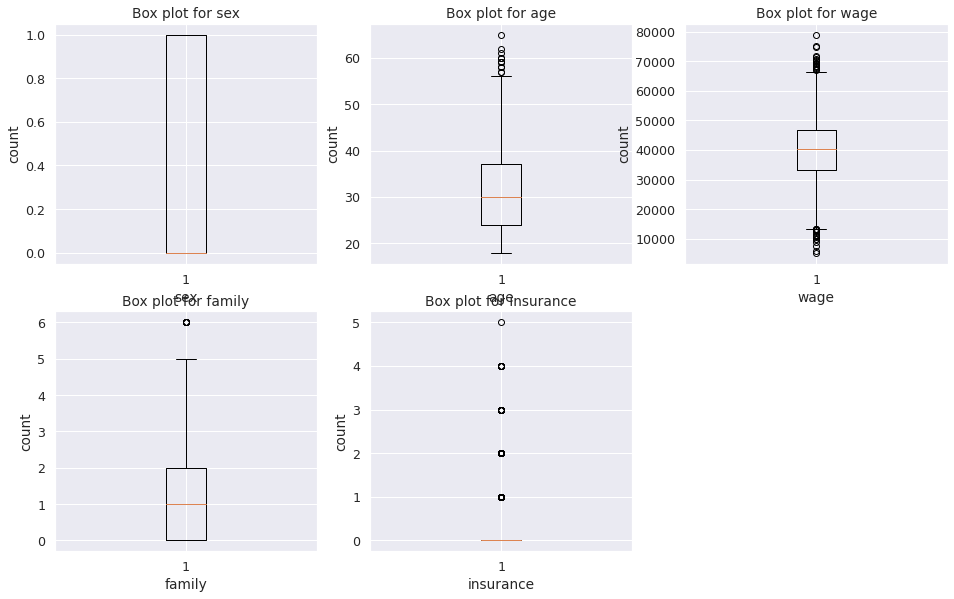

In [40]:
# цикл для проверки данных на выбросы из статьи: 
# построит для всех признаков формата int и float ящики с усами:

i = 1
plt.figure(figsize=(16,15))
for col_name in list(df.columns):
    if((df[col_name].dtypes=='int64' or df[col_name].dtypes=='float64') and col_name != 'charges'):
        plt.subplot(3,3, i)
        plt.boxplot(df[col_name])
        plt.xlabel(col_name)
        plt.ylabel('count')
        plt.title(f"Box plot for {col_name}")
        i += 1
plt.show()

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Если признаки умножаются на обратимую матрицу, результаты предсказания линейной регрессии не меняются.

**Обоснование:**

Для модели на преобразованных признаках (признаки умноженные на обратимую квадратную матрицу,размер которой равен размеру признаков). Предсказания:

$$
a' = X'w = (XP)w'
$$
Где $P$ - обратимая квадратная матрица. <br>
Нужно доказать, что $a = a'$ 
<br><br>
Запишем формулу для $w'$

$$
w' = ((XP)^T (XP)) ^{-1} (XP)^T y
$$

Раскроем скобки используя свойства операций над матрицами (определение обратной матрицы $A*A^{-1} = E$, а также свойство единичной матрицы $A*E = A$). Поскольку матрица признаков $X$ в общем (и данном) случае прямоугольная, для неё не существует обратной матрицы. Значит не стоит раскрывать скобки так, чтобы возникала операция поиска ($X^{-1}$). 

$$
w' = ((XP)^T (XP)) ^{-1} (XP)^T y
$$
<br><br>
$$
w' = (P^T*X^T*X*P) ^{-1} *P^T* X^T* y
$$
<br><br>
Обратим часть множителей из скобок обращения, чтобы в скобках осталось $(X^T X)^{-1}$ :
<br><br>
$$
w' = (P^T)^{-1} * (X^T*X)^{-1} *P^{-1} *P^T* X^T* y
$$
<br><br>
По определению обратной матрицы $(P^T)^{-1}*P^T = E$, т.е. единичная матрица, умножение на которую ничего не меняет, соответственно ее можно исключить из уравнения. Остаенется:
<br><br>
$$
w' = (X^T*X)^{-1}* X^T* y * P^{-1}
$$
<br><br>
Поскольку $w = (X^T X)^{-1} * X^T * y$, уравнение выше можно переписать так:
<br><br>
$$
w' = P^{-1}*w
$$
<br><br>
Подставляем новое уравнение для $w'$ в формулу для $a' = (XP)w'$, получаем:
<br><br>
$$
a' = (XP)* P^{-1}*w
$$
<br><br>
Раскрываем скобки: $P*P^{-1} = E$ по определению обратной матрицы, остается:
<br><br>
$$
a' = X*w = a
$$
<br><br>
Предсказания линейной регрессии на признаках до умножения на обратимую квадратную матрицу размер которой равен количеству признаков и после не будут отличаться. Значит и R2 будет тот же.  

## Алгоритм преобразования

**Алгоритм**<br><br>
Данные клиентов преобразуются в прямоугольную матрицу и умножаются на обратимую квадратную матрицу, размер которой равен количеству признаков клиентов.<br><br>
Чтобы генерируемая матрица наверняка была обратимой ее необходимо сгенерировать случайно, указав в качестве аргументов размера матрицы - ширину матрицы с клиентскими данными (т.е. количество признаков в ней).<br><br>
В алгоритм также необходимо добавить проверку на обратимость генерируемой матрицы (хоть это и крайне маловероятно). Его можно выполнить через определение обратимой матрицы $A*A^{-1} = E$ : произведение даст единичную квадратную матрицу с теми же размерами, что у сгенерированной обратичной. 
<br><br>
Если случайно сгенерированная квадратная матрица оказалась необратимой, необходимо повторить генерирование и проверку до тех пор, пока сгенерированная матрица не окажется обратимой. 
<br><br>
Алгоритм преобразования можно записать в виде функции ниже:

In [9]:
# алгоритм преобразования фичей
def cripto(features):
    features = features.values
    m = np.random.random((features.shape[1], features.shape[1]))
    m_inv = np.linalg.inv(m)
    if np.allclose(np.dot(m, m_inv), np.eye(m.shape[0])) == True: # если произведение обратной матрицы на саму 
        return features @ m
    else: 
        return 'сгенерированная случайная квадратная матрица оказалась необратимой' 

In [10]:
# через while должно быть как-то так:

def cripto_2(features):
    features = features.values
    m = np.random.random((features.shape[1], features.shape[1]))
    while np.allclose(np.dot(m, np.linalg.inv(m)), np.eye(m.shape[0])) == False: # если не обратимая 
        m = np.random.random((features.shape[1], features.shape[1])) # генерируй снова
    else: 
        return features @ m


**Обоснование**
<br><br>
Из формул и обоснования выше следует, что, если признаки умножаются на обратимую матрицу, результаты предсказания линейной регрессии не меняются. Меняются только данные клиентов. Это и делаем. 

## Проверка алгоритма

In [23]:
# посчитаем R2 линейной регрессии до преобразования фичей
model1 = LinearRegression()
model1.fit(features, target)
predictions = model1.predict(features)

print('R2 линейной регрессии до изменения признаков', r2_score(target, predictions))

R2 линейной регрессии до изменения признаков 0.42494550308169177


In [31]:
print('коэффициенты при переменных в модели до изменения признаков', model1.coef_)

коэффициенты при переменных в модели до изменения признаков [ 7.92580563e-03  3.57083050e-02 -1.70081903e-07 -1.35676627e-02]


In [37]:
# вспомним новые названия признаков
print(df.head())

   sex  age   wage  family  insurance
0    1   41  49600       1          0
1    0   46  38000       1          1
2    0   29  21000       0          0
3    0   21  41700       2          0
4    1   28  26100       0          0


In [38]:
import statsmodels.api as sm
from scipy import stats

X = df.drop('insurance', axis=1)
y = df['insurance']

X2 = sm.add_constant(X) 
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              insurance   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     922.8
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:40:29   Log-Likelihood:                -1862.8
No. Observations:                5000   AIC:                             3736.
Df Residuals:                    4995   BIC:                             3768.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9382      0.029    -32.516      0.0

In [32]:
# получили новые фичи зашифрованные в виде матрицы c помощью функции 
new_features = cripto(features)

In [33]:
new_features = cripto_2(features)

In [34]:
# посчитаем R2 линейной регрессии после преобразования фичей
model2 = LinearRegression()
model2.fit(new_features, target)
predictions = model2.predict(new_features)

print('R2 линейной регрессии после изменения признаков', r2_score(target, predictions))

R2 линейной регрессии после изменения признаков 0.42494550308169565


In [35]:
print('коэффициенты при переменных в модели до изменения признаков', model2.coef_)

коэффициенты при переменных в модели до изменения признаков [-0.13710392 -0.08814385  0.09447209  0.04751688]


**Вывод:** 
<br><br>
Получили данные клиентов страховой компании в форме датафрейма.
<br><br>
Разработали метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.
<br><br>
**Алгоритм преобразования**<br><br>
Данные клиентов преобразуются в прямоугольную матрицу.  Полученная матрица умножается на генерируемую обратимую квадратную матрицу, размер которой равен количеству признаков клиентов.<br><br>
Чтобы генерируемая матрица наверняка была обратимой ее необходимо сгенерировать случайно, указав в качестве аргументов размера матрицы - ширину матрицы с клиентскими данными (т.е. количество признаков в ней).<br><br>
В алгоритм добавлена проверка на обратимость генерируемой матрицы. Если случайно сгенерированная квадратная матрица оказалась необратимой, необходимо повторить генерирование и проверка на обратимость происходят до тех пор, пока сгенерированная матрица не окажется обратимой.<br><br>
Применимость такого алгоритма обоснована теоретически и эмпирически.<br><br>
R2 линейной регрессии предсказывающей размер страховых выплат до преобразования признаков и поле преобразования - один и тот же 0.424.<br><br>
Однако коэффициенты в уравнении линейной регресси при признаках после их изменения становятся не интерпретируемыми (отличаются от тех, которые были до изменения признаков).
<br><br>